### Análisis de tiempos de autosurtido Noviembre 2020 - Febrero 2021
#### Este análisis tiene como objetivo encontrar los talleres/agencias que cumplen con los tiempos meta de autosurtido y cuántos cumplen con las fechas promesa de entrega de los vehículos.

In [61]:
import pyodbc
import datetime as td
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Glancing at the excel file that contains information about 74 issues
excel = pd.read_excel(r"D:\Users\430008252\OneDrive - HDI Seguros\Documentos\AutoSurtido\CDR-AUTOSURTIDO_18-01-2021.xlsx")
excel.head()

,NIP_SUCURSAL,RFC,RAZONSOCIAL,NOMBRECOMERCIAL_CDR,OFICINAASEGURADORA,REGIONAL,MONTOAUTOSURTIDO
0,298742-25478,SLP860522482,SANROMAN LAMINADOS Y PINTURAS ESPECIALIZADOS S...,SANROMAN LAMINADOS Y PINTURAS ESPECIALIZADOS,LEON,BAJIO,13000
1,599516-22329,SASM800712BW3,MIGUEL SANROMAN SASHIDA,SANROMAN LAS TORRES,LEON,BAJIO,13000
2,1947654-36682,LAM100601LF5,LAMINAUTOS SA DE CV,LAMINAUTOS,LEON,BAJIO,13000
3,2831677-37961,VIPA801021FJ5,ALBERTO VILLASENOR PANDURO,QUALITY CAR MORELIA,MORELIA,OCCIDENTE,10500
4,2785226-37885,FAU931014QC1,FUERZA AUTOMOTRIZ SA DE CV,FUERZA AUTOMOTRIZ MICHOACAN,MORELIA,OCCIDENTE,10500


In [62]:
 # Reading database connection information from files
 server_file = open('server.sql','r')
database_file = open('database.sql', 'r')
# Settings to connect with the database
# Settings to connect with the database
server = server_file.readline()
database = database_file.readline()
DWH = pyodbc.connect(r'DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';TRUSTED_CONNECTION=TRUE')
# Queries from DWH
Tb_BI_GrlSinValuacion = pd.read_sql_query("""SELECT
    ValLst_NumeroExpediente
    , IdOficinaAtencion
    , FechaAutorizacionValuacion,FechaSolicitudRefacc
    , FechaEntregaRefacc
    , FechaPromesa
    , FechaEntrega
    , MontoRefacciones
    , MontoManoObra
    , NumeroTotalPiezas
    , TipoCentroReparacion
    , CONCAT(NipTaller, SucursalTaller) AS NipSucursal
    , Taller
    
    FROM Tb_BI_GrlSinValuacion
    
    WHERE
        FechaAutorizacionValuacion >= '2020-11-01 00:00:00'
        AND FechaAutorizacionValuacion < '2021-02-01'
        AND TipoProceso = 'EN REPARACION'
        AND IdLineaNegocio = 4
        AND NombreValuador NOT IN ('LUIS RODRIGUEZ','ERICK GONZALEZ','ALFONSO CRUZ','ALEJANDRO VIGIL','FERNANDO ROMERO','DAVID SILVA BERNAL')
        """,DWH).dropna()

Vw_Bi_GrlSinValuacion_Refacciones = pd.read_sql_query("""SELECT
    [ID Valuación]
    , [Oficina de Atención]
    , [Nombre taller]
    , [Descripción Homologada (calculado)]
    , [Origen de la refacción (Genérica, Original, TOT, Usada)]
    , [Precio Valuado]
    , FechaAsignacion
    , FechaPromesaEntrega
    , FechaEntregaProveedor
    , FechaRecepcion
    , CONCAT(NipProveedor, IdSucursal) AS NipSucursal

    FROM Vw_Bi_GrlSinValuacion_Refacciones

    WHERE

        [ID Valuación] IN 
            (SELECT ValLst_NumeroExpediente
            
            FROM Tb_BI_GrlSinValuacion
            
            WHERE FechaAutorizacionValuacion >= '2020-11-01 00:00:00'
            AND FechaAutorizacionValuacion < '2021-02-01'
            AND TipoProceso = 'EN REPARACION'
            AND IdLineaNegocio = 4
            AND NombreValuador NOT IN ('LUIS RODRIGUEZ','ERICK GONZALEZ','ALFONSO CRUZ','ALEJANDRO VIGIL','FERNANDO ROMERO','DAVID SILVA BERNAL')
            )
        AND
        [Auto surtido (calculado)] = 'Si' """,DWH).dropna()
Vw_bi_SinModeloMetas = pd.read_sql_query("""SELECT

    Periodo
    , Oficina
    , TiempoSurtidoRefacciones
    , CumplimientoFechaPromesa

    FROM Vw_bi_SinModeloMetas

    WHERE Periodo >= 202011
    AND Periodo < 202102""",DWH).dropna()

#### La tabla Tb_BI_GrlSinValuacion contiene información individual de cada valuación

In [63]:
# Glancing at the data frame
Tb_BI_GrlSinValuacion.head()

,ValLst_NumeroExpediente,IdOficinaAtencion,FechaAutorizacionValuacion,FechaSolicitudRefacc,FechaEntregaRefacc,FechaPromesa,FechaEntrega,MontoRefacciones,MontoManoObra,NumeroTotalPiezas,TipoCentroReparacion,NipSucursal,Taller
0,11149-21A1,5,2021-01-25 10:14:53.260,2021-01-25 16:44:58.630,2021-02-03 10:32:17.287,2021-03-15,2021-02-18 16:21:52.360,5281.87,7501.31,3.0,AGENCIA,29769725521,VAMSA LAS FUENTES
2,135750-20A1,34,2020-12-10 09:58:49.447,2020-12-15 12:37:15.887,2021-01-27 18:10:24.493,2021-01-19,2021-02-09 13:56:52.083,54754.00,19053.59,22.0,AGENCIA MULTIMARCA,27968536648,GRUPO MOTORMEXA MANZANILLO
3,1691-21A1,5,2021-01-25 10:57:35.240,2021-01-25 10:57:34.970,2021-01-25 18:52:46.113,2021-02-01,2021-01-25 18:58:10.293,1485.50,7700.85,2.0,AGENCIA,129290934310,WOLFSBURG DE OCCIDENTE
4,187855-20A1,33,2020-11-04 18:10:35.093,2020-11-04 18:10:34.817,2020-11-14 13:40:43.143,2020-11-27,2020-11-17 16:40:14.147,6382.56,3818.72,4.0,AGENCIA,27768625770,AUTOMOTRIZ TANGAMANGA
5,208619-20A1,24,2020-12-03 18:44:07.253,2020-12-03 18:44:07.007,2021-01-05 16:31:39.537,2021-01-12,2021-01-13 14:23:24.220,10764.01,3380.49,7.0,AGENCIA,27749825907,AUTOSUR MERIDA


In [64]:
# Checking the data types in each column
Tb_BI_GrlSinValuacion.IdOficinaAtencion = Tb_BI_GrlSinValuacion.IdOficinaAtencion.astype("int")
Tb_BI_GrlSinValuacion.dtypes

ValLst_NumeroExpediente               object
IdOficinaAtencion                      int32
FechaAutorizacionValuacion    datetime64[ns]
FechaSolicitudRefacc          datetime64[ns]
FechaEntregaRefacc            datetime64[ns]
FechaPromesa                  datetime64[ns]
FechaEntrega                  datetime64[ns]
MontoRefacciones                     float64
MontoManoObra                        float64
NumeroTotalPiezas                    float64
TipoCentroReparacion                  object
NipSucursal                           object
Taller                                object
dtype: object

In [65]:
# Setting data type values to the correct ones
Tb_BI_GrlSinValuacion = Tb_BI_GrlSinValuacion.astype({"ValLst_NumeroExpediente":"category","IdOficinaAtencion":"category","NumeroTotalPiezas":"int","TipoCentroReparacion":"category", "NipSucursal":"category","Taller":"category"})
Tb_BI_GrlSinValuacion.dtypes

ValLst_NumeroExpediente             category
IdOficinaAtencion                   category
FechaAutorizacionValuacion    datetime64[ns]
FechaSolicitudRefacc          datetime64[ns]
FechaEntregaRefacc            datetime64[ns]
FechaPromesa                  datetime64[ns]
FechaEntrega                  datetime64[ns]
MontoRefacciones                     float64
MontoManoObra                        float64
NumeroTotalPiezas                      int32
TipoCentroReparacion                category
NipSucursal                         category
Taller                              category
dtype: object

#### La tabla Vw_Bi_GrlSinValuacion_Refacciones contiene información de todas las refacciones asociadas a una valuación. 

In [66]:
# Glancing at the data frame
Vw_Bi_GrlSinValuacion_Refacciones.head()

,ID Valuación,Oficina de Atención,Nombre taller,Descripción Homologada (calculado),"Origen de la refacción (Genérica, Original, TOT, Usada)",Precio Valuado,FechaAsignacion,FechaPromesaEntrega,FechaEntregaProveedor,FechaRecepcion,NipSucursal
0,210480-20T1,4,"RAFEDHER AUTOMOTRIZ, S.A. DE C.V.",PARRILLA,GENUINA,715.44,2020-12-01 16:33:52.257,2000-01-01 12:00:00,2020-12-12 09:37:19.670,2020-12-11 16:16:09.383,52727032096
1,210480-20T1,4,"RAFEDHER AUTOMOTRIZ, S.A. DE C.V.",RIN,GENUINA,329.11,2020-12-01 16:33:52.257,2000-01-01 12:00:00,2020-12-12 09:37:16.070,2020-12-11 16:16:15.877,52727032096
2,210480-20T1,4,"RAFEDHER AUTOMOTRIZ, S.A. DE C.V.",EMBLEMA,GENUINA,373.47,2020-12-01 16:33:52.257,2000-01-01 12:00:00,2020-12-12 09:37:17.323,2020-12-11 16:16:04.663,52727032096
3,210480-20T1,4,"RAFEDHER AUTOMOTRIZ, S.A. DE C.V.",FARO,GENUINA,2459.05,2020-12-01 16:33:52.257,2000-01-01 12:00:00,2020-12-12 09:37:16.720,2020-12-05 13:52:38.767,52727032096
4,210480-20T1,4,"RAFEDHER AUTOMOTRIZ, S.A. DE C.V.",FACIA DELANTERA,GENUINA,4207.10,2020-12-01 16:33:52.257,2000-01-01 12:00:00,2020-12-12 09:37:14.500,2020-12-05 13:52:24.867,52727032096


In [67]:
# Renaming columns whose name could be an issue
Vw_Bi_GrlSinValuacion_Refacciones.columns = ["IDValuacion","IDOficinaAtencion","NombreTaller","DescripcionHomologada","OrigenRefaccion","PrecioValuado","FechaAsignacion","FechaPromesaEntrega","FechaEntregaProveedor","FechaRecepcion","NipSucursal"]
# Checking the data types in each columns
Vw_Bi_GrlSinValuacion_Refacciones.IDOficinaAtencion = Vw_Bi_GrlSinValuacion_Refacciones.IDOficinaAtencion.astype("int")
Vw_Bi_GrlSinValuacion_Refacciones.dtypes

IDValuacion                      object
IDOficinaAtencion                 int32
NombreTaller                     object
DescripcionHomologada            object
OrigenRefaccion                  object
PrecioValuado                   float64
FechaAsignacion          datetime64[ns]
FechaPromesaEntrega      datetime64[ns]
FechaEntregaProveedor    datetime64[ns]
FechaRecepcion           datetime64[ns]
NipSucursal                      object
dtype: object

In [68]:
# Setting data type values to the correct ones
Vw_Bi_GrlSinValuacion_Refacciones = Vw_Bi_GrlSinValuacion_Refacciones.astype({"IDValuacion":"category", "IDOficinaAtencion":"category","NombreTaller":"category","DescripcionHomologada":"category","OrigenRefaccion":"category", "NipSucursal":"category"})
Vw_Bi_GrlSinValuacion_Refacciones.dtypes

IDValuacion                    category
IDOficinaAtencion              category
NombreTaller                   category
DescripcionHomologada          category
OrigenRefaccion                category
PrecioValuado                   float64
FechaAsignacion          datetime64[ns]
FechaPromesaEntrega      datetime64[ns]
FechaEntregaProveedor    datetime64[ns]
FechaRecepcion           datetime64[ns]
NipSucursal                    category
dtype: object

#### La tabla Vw_bi_SinModeloMetas contiene información de los tiempos meta de surtido por oficina

In [69]:
# Glancing at the data frame
Vw_bi_SinModeloMetas.head()

,Periodo,Oficina,TiempoSurtidoRefacciones,CumplimientoFechaPromesa
0,202011,3,5.60,0.72
1,202011,4,5.12,0.72
2,202011,5,5.00,0.72
3,202011,6,6.16,0.72
4,202011,7,5.76,0.72


### Para este análisis se buscará cuántas refacciones cumplen con los tiempos meta de surtido.

De la tabla Vw_Bi_GrlSinValuacion_Refacciones, se evaluará -donde sea posible- qué tantos proveedores sí cumplen con sus fechas de entrega (en los casos que sea posible).

De la tabla Tb_BI_GralSinValuacion se evaluará cuántos talleres cumplieron con los tiempos meta utilizando también la tabla Vw_bi_SinModelosMetas.

#### El primer paso será asignar como NULL todas las fechas de Vw_Bi_GralSinValuacion correspondientes al año 2000

In [70]:
# Assigning pandas.Not a Time value to 2000 year dates
Vw_Bi_GrlSinValuacion_Refacciones.loc[Vw_Bi_GrlSinValuacion_Refacciones['FechaAsignacion']<min(Tb_BI_GrlSinValuacion.FechaAutorizacionValuacion),'FechaAsignacion']= pd.NaT
Vw_Bi_GrlSinValuacion_Refacciones.loc[Vw_Bi_GrlSinValuacion_Refacciones['FechaPromesaEntrega']<min(Tb_BI_GrlSinValuacion.FechaAutorizacionValuacion),'FechaPromesaEntrega']= pd.NaT
Vw_Bi_GrlSinValuacion_Refacciones.loc[Vw_Bi_GrlSinValuacion_Refacciones['FechaRecepcion']<min(Tb_BI_GrlSinValuacion.FechaAutorizacionValuacion),'FechaRecepcion']= pd.NaT
Vw_Bi_GrlSinValuacion_Refacciones.loc[Vw_Bi_GrlSinValuacion_Refacciones['FechaEntregaProveedor']<min(Tb_BI_GrlSinValuacion.FechaAutorizacionValuacion),'FechaEntregaProveedor']= pd.NaT

In [71]:
# Complete data set (all Dates are valid)
refacCompleto = Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
# Absolutelly crap data set (none of the date columns is valid)
refacNAS = Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
# Data set with FechaAsignacion
refacAs = Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refacFPE= Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refacFE = Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refacRe = Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac12 = Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac23 = Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac34 = Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac13 = Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac14 = Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac24 = Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac123= Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac124= Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac134= Vw_Bi_GrlSinValuacion_Refacciones[pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]
refac234= Vw_Bi_GrlSinValuacion_Refacciones[pd.isnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaAsignacion) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaEntregaProveedor) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaPromesaEntrega) & pd.notnull(Vw_Bi_GrlSinValuacion_Refacciones.FechaRecepcion)]

In [72]:
# Checking the number of complete cases the main data frame has
print("Del total de datos, el",round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refacCompleto.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% está completo.")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refacNAS.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% no contiene ninguna fecha para evaluar")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refacAs.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha de Asignación")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refacRe.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha de Recepción")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refacFE.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha de Entrega")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac12.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha de Asignación y promesa de entrega")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac23.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha promesa entrega y entrega proveedor")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac34.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha entrega y recepción")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac13.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha Asignación y entrega proveedor")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac14.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha Asignación y recepción")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac24.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha promesa entrega y recepción")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac123.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha Asignacion, promesa y entrega")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac124.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha Asignacion, promesa y recepción")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac234.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha Promesa, entrega y recepción")
print(round(100-(Vw_Bi_GrlSinValuacion_Refacciones.shape[0]-refac134.shape[0])/Vw_Bi_GrlSinValuacion_Refacciones.shape[0] *100,2),"% solo tiene Fecha Asignación, entrega y recepción")



Del total de datos, el 6.42 % está completo.
0.27 % no contiene ninguna fecha para evaluar
4.59 % solo tiene Fecha de Asignación
0.2 % solo tiene Fecha de Recepción
0.03 % solo tiene Fecha de Entrega
0.12 % solo tiene Fecha de Asignación y promesa de entrega
0.0 % solo tiene Fecha promesa entrega y entrega proveedor
0.02 % solo tiene Fecha entrega y recepción
0.44 % solo tiene Fecha Asignación y entrega proveedor
13.09 % solo tiene Fecha Asignación y recepción
0.0 % solo tiene Fecha promesa entrega y recepción
0.01 % solo tiene Fecha Asignacion, promesa y entrega
74.09 % solo tiene Fecha Asignacion, promesa y recepción
0.0 % solo tiene Fecha Promesa, entrega y recepción
0.7 % solo tiene Fecha Asignación, entrega y recepción


In [73]:
# Joining different data frames with manageable dates
datosRefac = pd.concat([refacCompleto,refac124,refac134, refac14],keys=["1234","124","134","14"])
# Calculating the number of days that elapsed between the request and delivery of the replacements
datosRefac["DiasEntrega"] = pd.to_timedelta(datosRefac[["FechaEntregaProveedor","FechaRecepcion"]].min(axis=1) -datosRefac.FechaAsignacion).dt.days
datosRefac["DiasEntrega"] = abs(datosRefac["DiasEntrega"])

In [74]:
a = datosRefac[datosRefac['DiasEntrega'] == 0].shape[0]
b = datosRefac[datosRefac['DiasEntrega'] == 1].shape[0]
b = datosRefac[datosRefac['DiasEntrega'] > 1].shape[0]
c = datosRefac[datosRefac['DiasEntrega'] <= 7].shape[0]
# df3[(df3.county=='Manhattan') & (df.party=='Democrat')]
datosRefac[(datosRefac.DiasEntrega > 28)].shape[0]

10128

### TOP 10 de refacciones más solicitadas, tiempo de solcitud y costo medio.
Se lleva a cabo un conteo de cuáles refacciones son más solicitadas, cuál es el costo medio de cada una y cuál es el tiempo promedio de entrega (diferencia entre la fecha en que se solicitó y en la que se entregó la pieza).

In [75]:
# Counting the number of each replacement by DesxripcionHomologada
contarRefac = datosRefac.groupby("DescripcionHomologada").count().sort_values(by = "IDValuacion", ascending = False)["IDValuacion"]
# Calculating the mean cost and delivery time for each replacment
costoTiempo = datosRefac.groupby("DescripcionHomologada").mean()#.sort_values(by = "IDValuacion", ascending = False)["IDValuacion"]
# Getting the TOP 10 of the replacements
refacTOP10 = pd.concat([contarRefac,costoTiempo], axis=1).sort_values(by = 'IDValuacion', ascending=False)[0:10]
refacTOP10.columns=['Piezas','Costo medio','Días entrega']# Renaming one column
refacTOP10[['Costo medio','Días entrega']] = round(refacTOP10[['Costo medio','Días entrega']],2)# Rounding values to two decimals

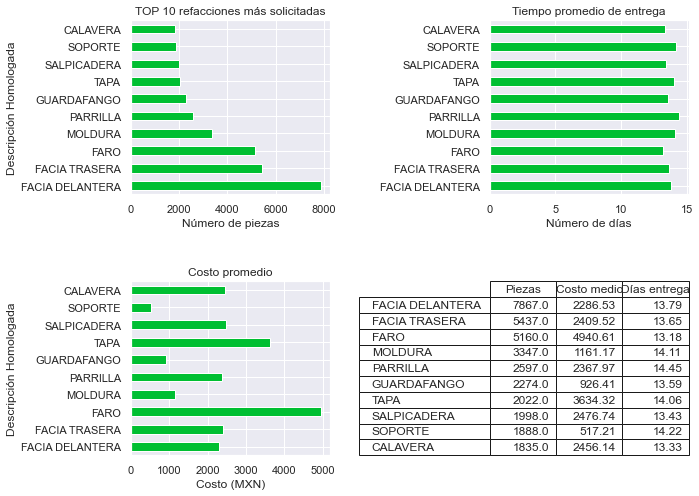

In [76]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))

ax1.set_title("TOP 10 refacciones más solicitadas")
refacTOP10['Piezas'].plot(kind='barh',color = "#00BF32", ax=ax1)
ax1.xaxis.set_label_text("Número de piezas")
ax1.yaxis.set_label_text("Descripción Homologada")

ax2.set_title("Tiempo promedio de entrega")
refacTOP10['Días entrega'].plot(kind='barh',color = "#00BF32", ax=ax2)
ax2.xaxis.set_label_text("Número de días")
ax2.yaxis.set_label_text("")

ax3.set_title("Costo promedio")
refacTOP10['Costo medio'].plot(kind='barh',color = "#00BF32", ax=ax3)
ax3.yaxis.set_label_text("Descripción Homologada")
ax3.xaxis.set_label_text("Costo (MXN)")

font_size=8
bbox = [0, 0, 1, 1]
ax4.axis('off')
mpl_table = ax4.table(cellText = refacTOP10.values, rowLabels = refacTOP10.index, bbox=bbox, colLabels=refacTOP10.columns)
mpl_table.auto_set_font_size(False)
# mpl_table.set_fontsize(font_size)
fig.subplots_adjust(hspace = 0.5, wspace=0.8)

In [77]:
# Subsetting the main data frame to get the most requested replacements
masSolicitadasTodas = datosRefac.groupby('DescripcionHomologada', observed = True)
# Getting the TOP 10 
masSolicitadasTOP10  = pd.DataFrame()
for refaccion in list(refacTOP10.index):
    masSolicitadasTOP10 = masSolicitadasTOP10.append(masSolicitadasTodas.get_group(refaccion))
masSolicitadasTOP10['DescripcionHomologada'] = masSolicitadasTOP10['DescripcionHomologada'].cat.remove_unused_categories()

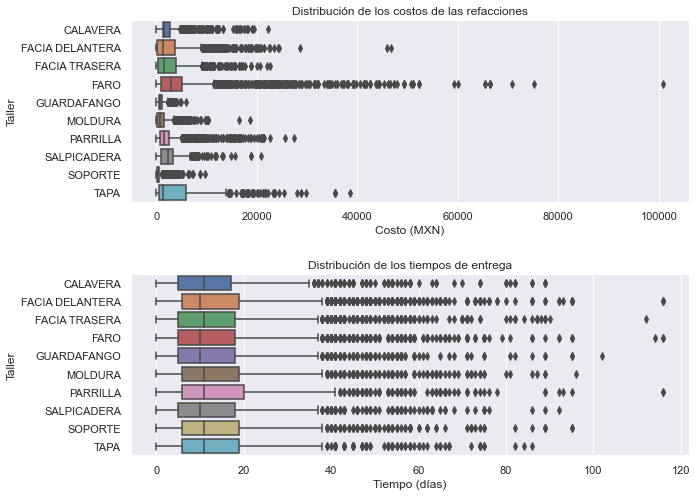

In [78]:
# Plotting data
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,8))

sns.boxplot(y="DescripcionHomologada", x="PrecioValuado", data = masSolicitadasTOP10, orient="h", ax=ax1)
ax1.yaxis.set_label_text("Taller")
ax1.xaxis.set_label_text("Costo (MXN)")
ax1.set_title("Distribución de los costos de las refacciones")

sns.boxplot(y="DescripcionHomologada", x="DiasEntrega", data = masSolicitadasTOP10, orient="h", ax=ax2)
ax2.yaxis.set_label_text("Taller")
ax2.xaxis.set_label_text("Tiempo (días)")
ax2.set_title("Distribución de los tiempos de entrega")

fig.subplots_adjust(hspace = 0.4)
plt.show()

### TOP 10 de talleres con más retraso en surtido

Se realiza un análisis de los diez talleres con los tiempos de autosurtido más altos, cuáles son las piezas que más solicitan y cuál es su costo promedio.

In [79]:
# Calculating the mean cost and delivery time for each workshop
meanTallerNoTOP10 = datosRefac.groupby('NombreTaller').mean().dropna()
meanTallerNoTOP10.columns = ['Costo medio', 'Días entrega']
medianTallerNoTOP10 = datosRefac.groupby('NombreTaller').median().dropna()
medianTallerNoTOP10.columns = ['Costo mediana', 'Entrega mediana']
datosTallerNoTOP10 = pd.concat([meanTallerNoTOP10, medianTallerNoTOP10],axis=1).sort_values(by='Días entrega', ascending=False)[0:10]

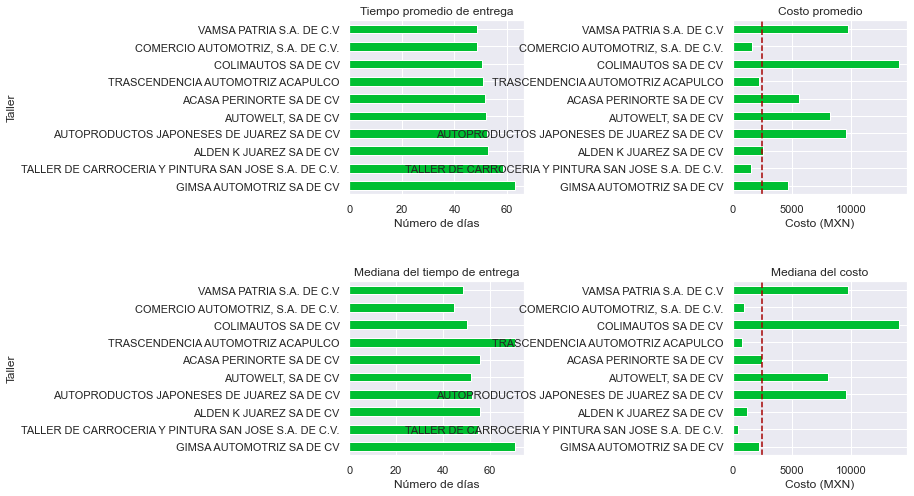

In [80]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))

ax1.set_title("Tiempo promedio de entrega")
datosTallerNoTOP10['Días entrega'].plot(kind='barh',color = "#00BF32", ax=ax1)
ax1.xaxis.set_label_text("Número de días")
ax1.yaxis.set_label_text("Taller")

ax2.set_title("Costo promedio")
datosTallerNoTOP10['Costo medio'].plot(kind='barh',color = "#00BF32", ax=ax2)
ax2.xaxis.set_label_text("Costo (MXN)")
ax2.yaxis.set_label_text("")
ax2.axvline(x=2500, color = "#A60000", linestyle = '--')

ax3.set_title("Mediana del tiempo de entrega")
datosTallerNoTOP10['Entrega mediana'].plot(kind='barh', color = "#00BF32", ax=ax3)
ax3.xaxis.set_label_text("Número de días")
ax3.yaxis.set_label_text("Taller")

ax4.set_title("Mediana del costo")
datosTallerNoTOP10["Costo mediana"].plot(kind='barh', color = "#00BF32", ax=ax4)
ax4.xaxis.set_label_text("Costo (MXN)")
ax4.yaxis.set_label_text("")
ax4.axvline(x=2500, color = "#A60000", linestyle = '--')

fig.subplots_adjust(hspace = 0.5, wspace=1.2)

### Análisis de los talleres cuyos promedios y medianas del costo excede los 2500 (MXN)

In [123]:
# Joining all the necessary data regarding the three workshops whose mean cost is too high

talleresCostosos = (datosRefac[datosRefac['NombreTaller']== 'COLIMAUTOS SA DE CV'].append(datosRefac[datosRefac['NombreTaller']== 'AUTOWELT, SA DE CV']).append(datosRefac[datosRefac['NombreTaller']== 'AUTOPRODUCTOS JAPONESES DE JUAREZ SA DE CV']).append(datosRefac[datosRefac['NombreTaller']== 'VAMSA PATRIA S.A. DE C.V']))
# talleresCostosos.boxplot(column = 'Dias')
test = talleresCostosos.groupby("NombreTaller", observed = True)
talleresCostosos.index = talleresCostosos.index.remove_unused_levels()

### Gráficos de caja para conocer la distribución de los tiempos de entrega y costos de los talleres con más retraso en el auto-surtido de refacciones

In [124]:
# Subsetting the whole replacement's data frame to get the anti TOP10 of the workshops
talleresLENTOS = pd.DataFrame()
for taller in list(datosTallerNoTOP10.index):
    talleresLENTOS = talleresLENTOS.append(datosRefac[datosRefac['NombreTaller'] == taller])
# Removing unsued categories
talleresLENTOS['NombreTaller'] = talleresLENTOS['NombreTaller'].cat.remove_unused_categories()

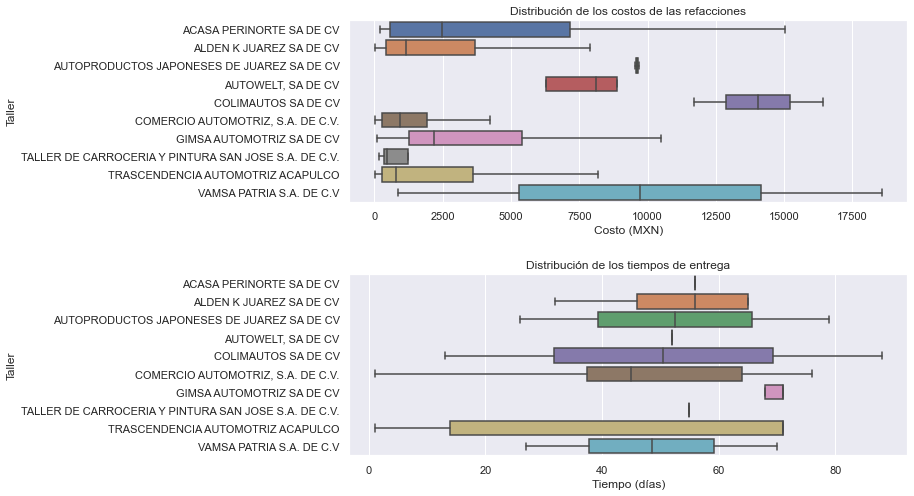

In [129]:
# Plotting data
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,8))

sns.boxplot(y="NombreTaller", x="PrecioValuado", data = talleresLENTOS, orient="h",  showfliers = False, ax=ax1)
ax1.yaxis.set_label_text("Taller")
ax1.xaxis.set_label_text("Costo (MXN)")
ax1.set_title("Distribución de los costos de las refacciones")

sns.boxplot(y="NombreTaller", x="DiasEntrega", data = talleresLENTOS, orient="h",  showfliers = False, ax=ax2)
ax2.yaxis.set_label_text("Taller")
ax2.xaxis.set_label_text("Tiempo (días)")
ax2.set_title("Distribución de los tiempos de entrega")

fig.subplots_adjust(hspace = 0.4)
plt.show()

### Revisión de los datos de los 3 talleres con costos y retrasos más altos

In [121]:
tres = talleresCostosos[talleresCostosos['NombreTaller'] == 'AUTOWELT, SA DE CV']
tres = tres.append(talleresCostosos[talleresCostosos['NombreTaller'] == 'COLIMAUTOS SA DE CV'])
tres = tres.append(talleresCostosos[talleresCostosos['NombreTaller'] == 'VAMSA PATRIA S.A. DE C.V'])
tres['NombreTaller'] = tres['NombreTaller'].cat.remove_unused_categories()

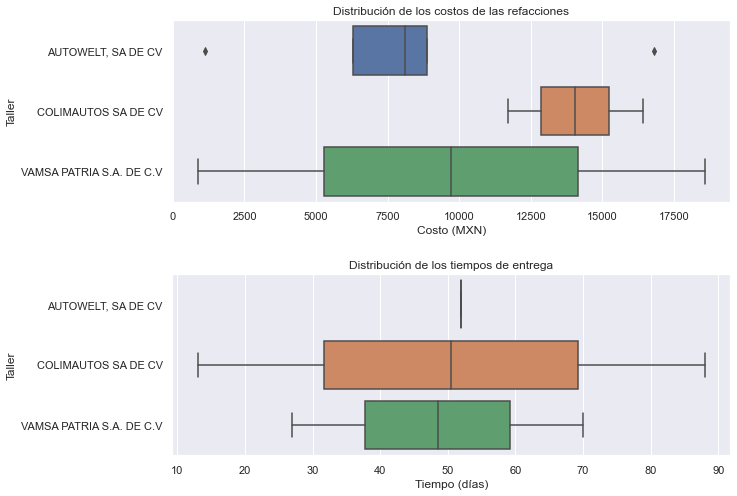

In [122]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,8))

sns.boxplot(y="NombreTaller", x="PrecioValuado", data=tres, orient="h", ax=ax1)
ax1.yaxis.set_label_text("Taller")
ax1.xaxis.set_label_text("Costo (MXN)")
ax1.set_title("Distribución de los costos de las refacciones")

sns.boxplot(y="NombreTaller", x="DiasEntrega", data=tres, orient="h", ax=ax2)
ax2.yaxis.set_label_text("Taller")
ax2.xaxis.set_label_text("Tiempo (días)")
ax2.set_title("Distribución de los tiempos de entrega")

fig.subplots_adjust(hspace = 0.4)
plt.show()

### Se calcula el número de siniestros atendidos por sucursal y el número de refacciones por siniestro. 

De la tabla de refacciones se hace una agrupación por número de sucursal y se cuentan todas las refacciones solicitadas por dicha sucursal. Posteriormente se realiza una operación similar con los siniestros y finalmente se concatenan ambas tablas para genererar una que contienga el número de sucursal, los siniestros atendidos y las refacciones solicitadas.

In [86]:
contarRefacciones = datosRefac.groupby('NipSucursal').count().sort_values(by = 'IDValuacion', ascending = False)
contarRefacciones.drop(contarRefacciones.iloc[:,1:], axis = 1, inplace = True)#Trimming the data frame to keep only a column with the number of sinisters
# Setting the index column as a normal column in the data frame
contarRefacciones.index.name = 'NipSucursal'
contarRefacciones.reset_index(inplace = True)
contarRefacciones.columns = ['NipSucursal', 'Refacciones solicitadas']# Nameing appropriately the columns

# Counting the number of sinisters per workshop
contarSiniestros = Tb_BI_GrlSinValuacion.groupby('NipSucursal').count().sort_values(by = 'ValLst_NumeroExpediente', ascending = False)
contarSiniestros.drop(contarSiniestros.iloc[:,1:], axis = 1, inplace = True) #Trimming the data frame to keep only a column with the number of sinisters
# Setting the index column as a normasl column in the data frame
contarSiniestros.index.name = 'NipSucursal'
contarSiniestros.reset_index(inplace = True)
contarSiniestros.columns = ['NipSucursal', 'Siniestros atendidos']

# Calculating the costs by workshop 
costoPiezaSiniestro = Tb_BI_GrlSinValuacion.groupby('NipSucursal').sum()

# Generating a data set with the whole information
siniestrosPiezas = contarSiniestros.merge(contarRefacciones, left_on='NipSucursal', right_on='NipSucursal').sort_values(by='Refacciones solicitadas', ascending = False)
# Mergeing the data about siniestros and replacements with the data about the costs
datosSinTaller = siniestrosPiezas.merge(costoPiezaSiniestro, left_on = 'NipSucursal', right_on = 'NipSucursal')
datosSinTaller = datosSinTaller.rename(columns={'MontoRefacciones':'Total refacciones', 'MontoManoObra':'Total mano obra', 'NumeroTotalPiezas':'Piezas reemplazadas' })

### Se calcula el número de piezas por siniestro
Se cuentan los de la tabla de valuaciones divididos por el número de piezas extraído de la tabla de valuaciones y por el número de piezas extraído de la tabla de refacciones. Similarmente, se calcula también el número de piezas de diferencia y los costos promedio de las piezas y de la mano de obra por siniestro.

In [87]:
# datosSinTaller['Piezas/siniestro'] = round(datosSinTaller['Refacciones solicitadas']/datosSinTaller['Siniestros atendidos'],2)
datosSinTaller.insert(loc=3,column = 'Piezas/siniestro', value = round(datosSinTaller['Refacciones solicitadas']/datosSinTaller['Siniestros atendidos'],2))
datosSinTaller.insert(loc=7, column = 'Pieza/siniestro(val)', value = round(datosSinTaller['Piezas reemplazadas']/datosSinTaller['Siniestros atendidos'],2))
datosSinTaller.insert(loc=8, column = 'Piezas sin info', value = datosSinTaller['Piezas reemplazadas'] - datosSinTaller['Refacciones solicitadas'])
datosSinTaller.insert(loc=9, column = 'Costo medio refacción', value = datosSinTaller['Total refacciones']/datosSinTaller['Piezas reemplazadas'])

In [88]:
# Tb_BI_GrlSinValuacion.merge(datosSinTaller, left_on=).head()
nombreTalleres = Tb_BI_GrlSinValuacion[['Taller','NipSucursal']].drop_duplicates()
# Tb_BI_GrlSinValuacion.groupby('Taller')
tablaTalleres = nombreTalleres.merge(datosSinTaller, left_on='NipSucursal', right_on='NipSucursal').sort_values(by='Refacciones solicitadas', ascending = False)


### Reuniendo todos los datos en una sola tabla
Se unen la tabla que contiene los nombres de los talleres con la tabla que contiene información sobre las refacciones y siniestros

In [89]:
# tablaTalleres = nombreTalleres.merge(datosSinTaller, left_on='NipSucursal', right_on='NipSucursal').sort_values(by='Refacciones solicitadas', ascending = False)
# tablaTalleres = tablaTalleres.set_index('NombreTaller')
# tablaTalleres.head(10)# Showing the first 10 values of the data

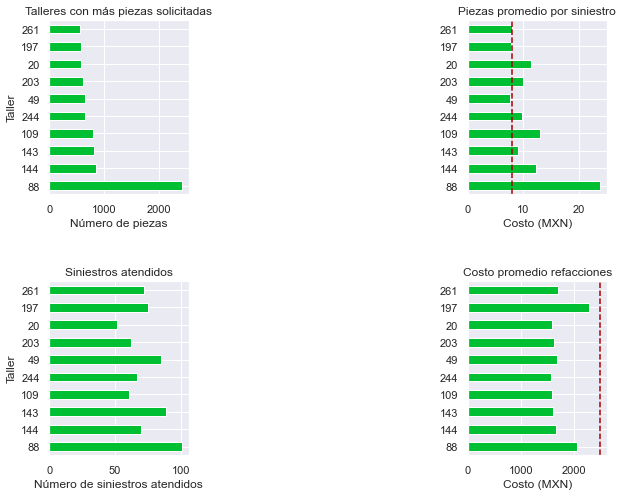

In [90]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))

ax1.set_title("Talleres con más piezas solicitadas")
tablaTalleres['Refacciones solicitadas'].sort_values(ascending = False)[0:10].plot(kind='barh',color = "#00BF32", ax=ax1)
ax1.xaxis.set_label_text("Número de piezas")
ax1.yaxis.set_label_text("Taller")

ax2.set_title("Piezas promedio por siniestro")
tablaTalleres.sort_values(by = 'Refacciones solicitadas', ascending = False)['Piezas/siniestro'][0:10].plot(kind='barh',color = "#00BF32", ax=ax2)
ax2.xaxis.set_label_text("Costo (MXN)")
ax2.yaxis.set_label_text("")
ax2.axvline(x=8, color = "#A60000", linestyle = '--')

ax3.set_title("Siniestros atendidos")
tablaTalleres.sort_values(by = 'Refacciones solicitadas', ascending = False)['Siniestros atendidos'][0:10].plot(kind='barh', color = "#00BF32", ax=ax3)
ax3.xaxis.set_label_text("Número de siniestros atendidos")
ax3.yaxis.set_label_text("Taller")

ax4.set_title("Costo promedio refacciones")
tablaTalleres.sort_values(by = 'Refacciones solicitadas', ascending = False)['Costo medio refacción'][0:10].plot(kind='barh', color = "#00BF32", ax=ax4)
ax4.xaxis.set_label_text("Costo (MXN)")
ax4.yaxis.set_label_text("")
ax4.axvline(x=2500, color = "#A60000", linestyle = '--')

fig.subplots_adjust(hspace = 0.5, wspace=2)

In [91]:
# Subsetting the whole replacement's data frame to get the TOP10 of the workshops
talleresMasPiezas = pd.DataFrame()
for taller in tablaTalleres.sort_values(by = 'Refacciones solicitadas', ascending = False)['NipSucursal'][0:10]:
    talleresMasPiezas = talleresMasPiezas.append(datosRefac[datosRefac['NipSucursal'] == taller])

talleresMasPiezas.index.name = 'NombreTaller'
talleresMasPiezas.reset_index(inplace=True)
talleresMasPiezas['NombreTaller'] = talleresMasPiezas['NombreTaller'].cat.remove_unused_categories()

In [92]:
# Subsetting the whole sinisters data frame to get the TOP10 of the workshops
tmp = pd.DataFrame()
for taller in tablaTalleres.sort_values(by = 'Refacciones solicitadas', ascending = False)['NipSucursal'][0:10]:
    tmp = tmp.append(Tb_BI_GrlSinValuacion[Tb_BI_GrlSinValuacion['NipSucursal']== taller])

tmp['Taller'] = tmp['Taller'].cat.remove_unused_categories()

In [93]:
tmp2 = tmp

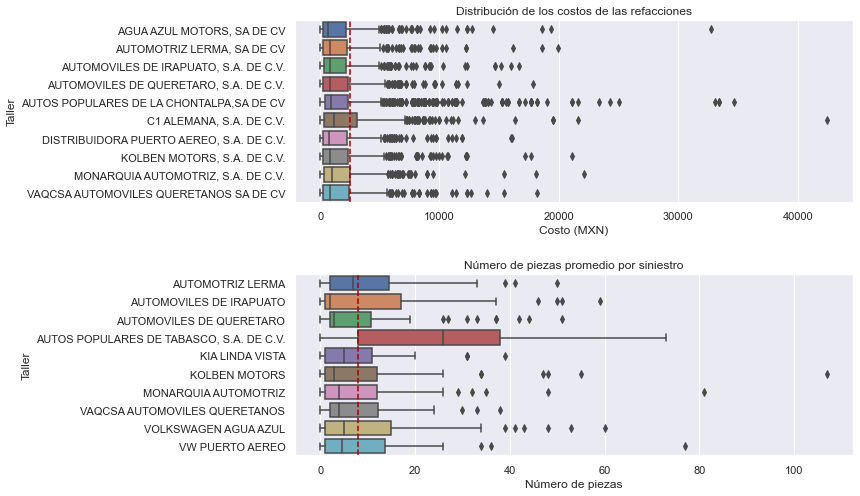

In [94]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,8))

sns.boxplot(y="NombreTaller", x="PrecioValuado", data=talleresMasPiezas, orient="h", ax=ax1)
ax1.yaxis.set_label_text("Taller")
ax1.xaxis.set_label_text("Costo (MXN)")
ax1.set_title("Distribución de los costos de las refacciones")
ax1.axvline(x=2500, color = "#A60000", linestyle = '--')

sns.boxplot(y='Taller', x='NumeroTotalPiezas', data=tmp2, orient="h", ax=ax2)
ax2.yaxis.set_label_text("Taller")
ax2.xaxis.set_label_text("Número de piezas")
ax2.set_title("Número de piezas promedio por siniestro")
ax2.axvline(x=8, color = "#A60000", linestyle = '--')

fig.subplots_adjust(hspace = 0.4)
plt.show()

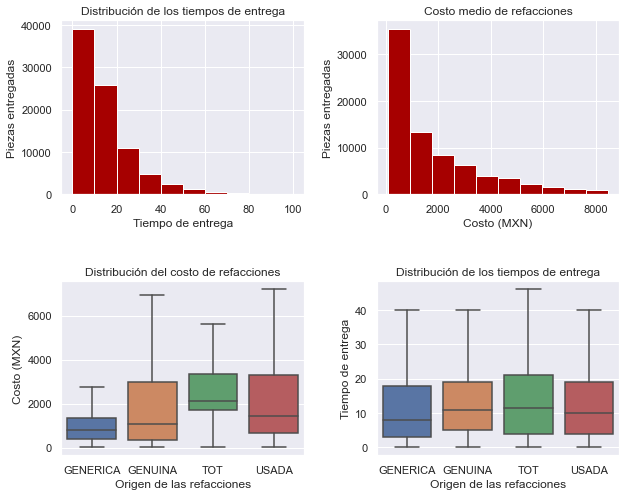

In [95]:
noOutliers = datosRefac.PrecioValuado.between(datosRefac.PrecioValuado.quantile(0.05),datosRefac.PrecioValuado.quantile(0.95))

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))


datosRefac.DiasEntrega.hist(ax= ax1, color = "#A60000", range = [0,100])
ax1.xaxis.set_label_text("Tiempo de entrega")
ax1.yaxis.set_label_text("Piezas entregadas")
ax1.set_title('Distribución de los tiempos de entrega')

datosRefac.PrecioValuado[noOutliers].hist(ax= ax2, color="#A60000")
ax2.xaxis.set_label_text("Costo (MXN)")
ax2.yaxis.set_label_text("Piezas entregadas")
ax2.set_title("Costo medio de refacciones")

sns.boxplot(x = "OrigenRefaccion", y="PrecioValuado", data = datosRefac,showfliers = False, ax=ax3)
ax3.xaxis.set_label_text("Origen de las refacciones")
ax3.yaxis.set_label_text("Costo (MXN)")
ax3.set_title("Distribución del costo de refacciones")

sns.boxplot(x = "OrigenRefaccion", y = "DiasEntrega", data = datosRefac,showfliers = False, ax=ax4)
ax4.xaxis.set_label_text("Origen de las refacciones")
ax4.yaxis.set_label_text('Tiempo de entrega')
ax4.set_title("Distribución de los tiempos de entrega")

fig.subplots_adjust(hspace = 0.5, wspace=0.3)

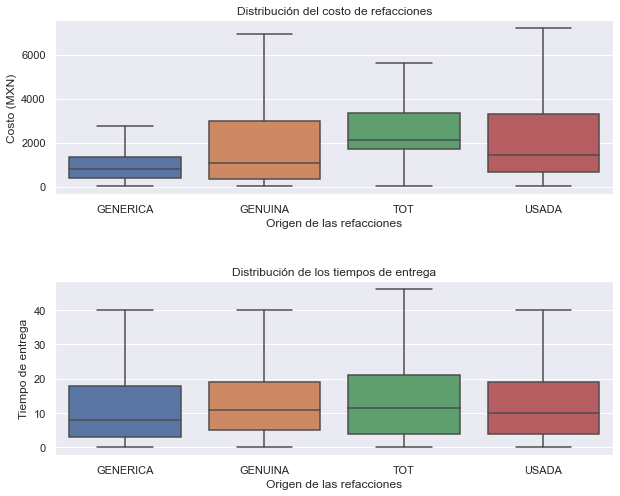

In [96]:
fig, [ax1, ax2]= plt.subplots(2, 1, figsize=(10,8))
sns.boxplot(x = "OrigenRefaccion", y="PrecioValuado", data = datosRefac, showfliers = False, ax=ax1)
ax1.xaxis.set_label_text("Origen de las refacciones")
ax1.yaxis.set_label_text("Costo (MXN)")
ax1.set_title("Distribución del costo de refacciones")

sns.boxplot(x = "OrigenRefaccion", y = "DiasEntrega", data = datosRefac, showfliers = False, ax=ax2)
ax2.xaxis.set_label_text("Origen de las refacciones")
ax2.yaxis.set_label_text('Tiempo de entrega')
ax2.set_title("Distribución de los tiempos de entrega")

fig.subplots_adjust(hspace = 0.5)